# Descriptive statistics and multi-boundary mapping

**Note:** This computational notebook replicates and extends the descriptive statistics of the following paper: Ingram, M. & Marchesini da Costa, M. (2019). [Political geography of violence: Municipal politics and homicide in Brazil](https://doi.org/10.1016/j.worlddev.2019.06.016). World Development, 124, 104592. Replication materials are available at https://doi.org/10.7910/DVN/NX5QIU

## Install and load libraries

In [ ]:
import time
t1 = time.perf_counter()

In [ ]:
# Adding necessary libraries to Google Colab environment

# Installing the 'contextily' library for adding basemaps to plots
!pip install contextily -q

# Installing additional libraries for spatial analysis and visualization
!pip install mapclassify -q  # Library for choropleth mapping

# Installing stargazer for regression tables
!pip install stargazer -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
# Load libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pylab import rcParams
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 72

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context(context="paper", font_scale=1.5, rc=None)
sns.set(font="serif")

import plotly.express as px
import plotly.graph_objects as go

import geopandas as gpd


import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer, LineLocation


import warnings
warnings.filterwarnings('ignore')


## Lis of main variables

| Name            | Label   | Description                                                                                                                                                                      |
|-----------------|---------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| HR Change       | DfHRElc | Difference between the two-year average of homicide rates in 2011-2012 and the two-year average in 2007-2008                                                                     |
| Margin of Victory | margin  | Margin of victory in mayoral election, calculated as the difference between the percentage of votes obtained by the winner of the election and the percentage of votes obtained by the second place candidate |
| Abstention      | Abstntn | Percent of voters that abstained from three consecutive elections as of 2010                                                                                                     |
| Alignment       | stalign | Party alignment of mayor and governor (1 if the party of the mayor elected in 2008 was the same as the party of the governor; 0 otherwise)                                    |
| PT              | PT      | Mayors from PT (Workers’ Party, PT)                                                                                                                                                                  |
| PSDB            | PSDB    | Mayors from PSDB                                                                                                                                                                 |
| PMDB            | PMDB    | Mayors from PMDB                                                                                                                                                                 |
| PopDensity      | lppdnst | Total population divided by territorial area covered by the municipality (logged)                                                                                               |
| YoungMalePct    | lpctppy | Percent of the population consisting of males ages $15-29$ (logged)                                                                                                              |
| GINI            | GINI    | GINI index (continuous variable; 0 for perfect income equality; 1 for totally concentrated income)                                                                               |
| HDI             | IDHM    | Municipal Human Development Index (continuous variable; 0 low development; 1 high development)                                                                                    |
| SingleMotherHH  | HHsinpr | Percent of households headed by mothers with no education and a child below 15 years old                                                                                          |
| Employment      | Ocp18ml | Percent of residents age 18 or over who are employed (i.e., adult employment rate)                                                                                              |
| BolsaFamilia   | CoverBF | Percent of poor families eligible for Bolsa Familia who are actually covered by Bolsa Familia (i.e., coverage rate)                                                           |


In [ ]:
variables = ["DfHRElc", "margin", "stalign", "Abstntn", "PMDB", "PSDB", "PT", "lppdnst", "lpctppy", "GINI", "IDHM", "HHsinpr", "Ocp18ml", "CoverBF"]

## Load data

In [ ]:
# Load municipal database
gdf = gpd.read_file("https://gist.github.com/cmg777/fe858a48ff7191b9c2a3aff7d6ddfd6f/raw/858272ce03d1b818429df3e7cead9e03ef7ec3b9/homicidesBRA_WD_20190318.geojson")
gdf[variables]

,DfHRElc,margin,stalign,Abstntn,PMDB,PSDB,PT,lppdnst,lpctppy,GINI,IDHM,HHsinpr,Ocp18ml,CoverBF
0,-0.29,0.067841,0.0,0.405,0.0,1.0,0.0,2.201981,-1.951197,0.48,0.577,9.76,53.21,106.32
1,-10.03,0.131541,0.0,1.138,0.0,0.0,0.0,3.814317,-2.082978,0.49,0.599,16.82,48.59,146.85
2,-4.84,1.000000,0.0,0.733,0.0,0.0,0.0,2.902913,-1.977853,0.50,0.585,14.28,49.09,107.47
3,2.51,0.259127,0.0,0.916,0.0,0.0,0.0,5.133008,-2.102252,0.49,0.639,18.25,55.87,108.13
4,9.48,1.000000,0.0,1.028,0.0,0.0,0.0,0.297633,-1.841872,0.56,0.564,8.49,47.92,106.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5557,-31.44,0.180333,0.0,2.196,0.0,0.0,0.0,1.056879,-1.934378,0.56,0.688,10.62,70.08,74.01
5558,-5.76,0.098015,0.0,2.082,0.0,0.0,1.0,-0.180308,-1.960205,0.54,0.689,12.90,66.26,73.10
5559,12.41,0.818463,0.0,0.890,0.0,0.0,0.0,1.440147,-2.039168,0.42,0.679,9.90,63.01,82.19
5560,6.46,0.027332,0.0,2.085,1.0,0.0,0.0,1.917569,-1.909069,0.48,0.703,12.70,72.42,88.21


In [ ]:
# Set projection and coordinates
gdf = gdf.set_crs(epsg=4326)
gdf['x_coor'] = gdf.centroid.x
gdf['y_coor'] = gdf.centroid.y

In [ ]:
# Load state boundaries
gdf1 = gpd.read_file("https://gist.github.com/cmg777/9ba073adb5bf4cd4f604643397660269/raw/168984a8650fdf4292289fb2804bee61356ffb51/estados_2010_noislands.geojson")
gdf1 = gdf1.to_crs(gdf.crs)

## Descriptive statistics

In [ ]:
df = gdf[variables].describe().round(2)
ds = df.T
ds

,count,mean,std,min,25%,50%,75%,max
DfHRElc,5562.0,1.80,14.45,-84.47,-4.46,0.00,8.66,96.98
margin,5562.0,0.20,0.24,0.00,0.05,0.12,0.24,1.00
stalign,5562.0,0.22,0.41,0.00,0.00,0.00,0.00,1.00
Abstntn,5562.0,0.77,0.55,0.00,0.41,0.68,1.02,9.30
PMDB,5562.0,0.22,0.41,0.00,0.00,0.00,0.00,1.00
PSDB,5562.0,0.14,0.35,0.00,0.00,0.00,0.00,1.00
PT,5562.0,0.10,0.30,0.00,0.00,0.00,0.00,1.00
lppdnst,5562.0,3.21,1.42,-2.03,2.45,3.19,3.94,9.47
lpctppy,5562.0,-2.03,0.11,-2.54,-2.09,-2.02,-1.95,-0.99
GINI,5562.0,0.49,0.07,0.28,0.45,0.49,0.54,0.80


In [ ]:
ds.to_csv('ds.csv', index=True)

## Map dependent variable

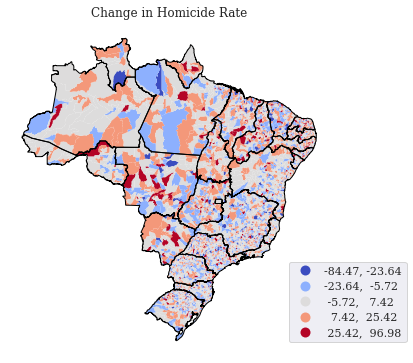

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the choropleth map of municipalities
gdf.plot(column='DfHRElc', cmap='coolwarm', linewidth=0.01, scheme='natural_breaks', k=5, legend=True, legend_kwds={'bbox_to_anchor': (1.25, 0.30)}, ax=ax)

# Add plot of state-level boundaries
gdf1.plot(facecolor='none', edgecolor='black', ax=ax)

# Set title and turn off axis
ax.set_title('Change in Homicide Rate', fontsize=12)
ax.axis("off")

# Save and display the plot
plt.savefig('mapY.png', dpi=150, bbox_inches='tight')
plt.show()

## Map main independent variables

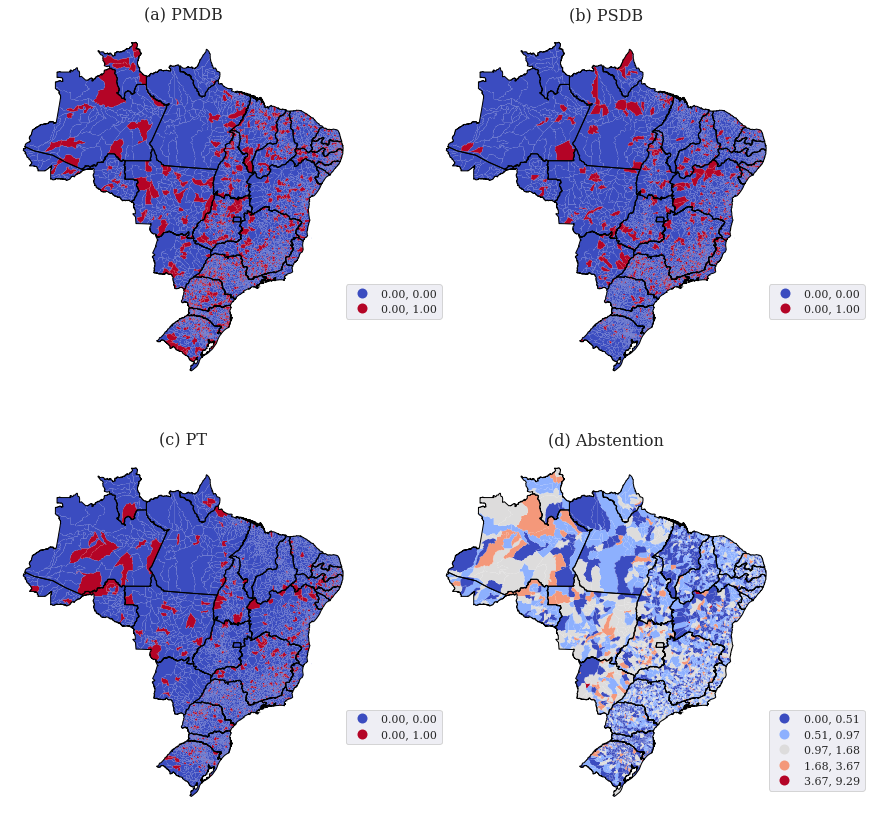

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

variablesX1 = ['PMDB', 'PSDB', 'PT', 'Abstntn']
titles = ['(a) PMDB', '(b) PSDB', '(c) PT', '(d) Abstention']

for i, var in enumerate(variablesX1):
    row = i // 2
    col = i % 2

    # Plot choropleth map
    gdf.plot(column=var, cmap='coolwarm', linewidth=0.01, scheme='natural_breaks', k=5, legend=True, legend_kwds={'bbox_to_anchor': (1.25, 0.30)}, ax=axes[row, col])

    # Plot boundary
    gdf1.plot(facecolor='none', edgecolor='black', ax=axes[row, col])

    # Turn off axis
    axes[row, col].axis("off")

    # Set title
    axes[row, col].set_title(titles[i], fontsize=16)

# Adjust layout
plt.tight_layout()

# Save and display the plot
plt.savefig('mapX1.png', dpi=72, bbox_inches='tight')
plt.show()

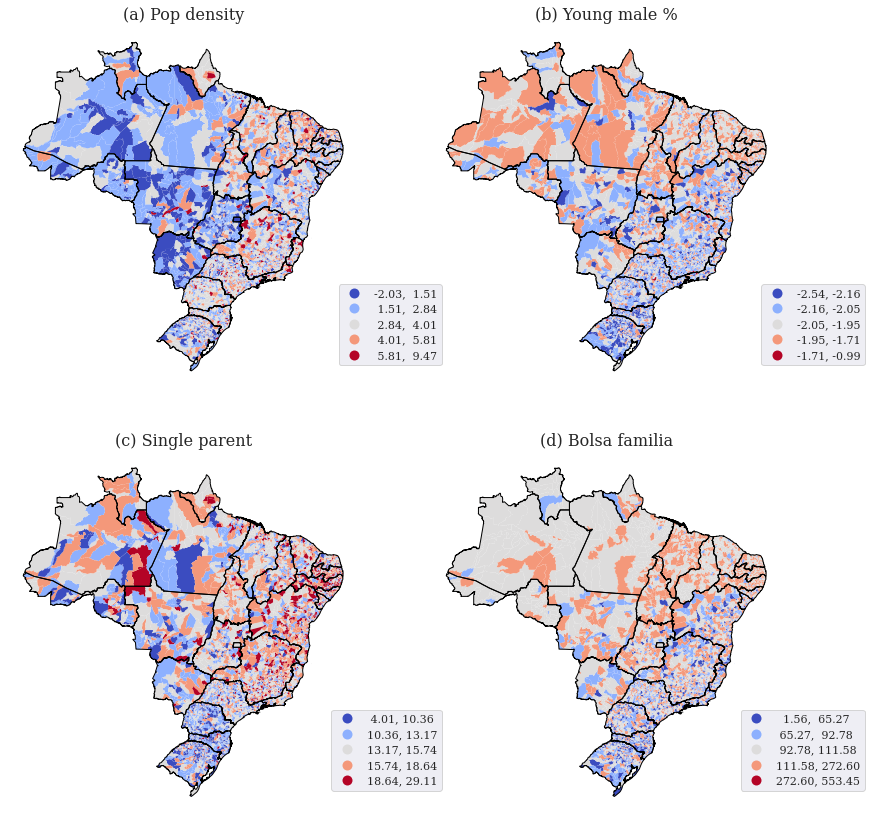

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

variablesX2 = ['lppdnst', 'lpctppy', 'HHsinpr', 'CoverBF']
titles = ['(a) Pop density', '(b) Young male %', '(c) Single parent', '(d) Bolsa familia']

for i, var in enumerate(variablesX2):
    row = i // 2
    col = i % 2

    # Plot choropleth map
    gdf.plot(column=var, cmap='coolwarm', linewidth=0.01, scheme='natural_breaks', k=5, legend=True, legend_kwds={'bbox_to_anchor': (1.25, 0.30)}, ax=axes[row, col])

    # Plot boundary
    gdf1.plot(facecolor='none', edgecolor='black', ax=axes[row, col])

    # Turn off axis
    axes[row, col].axis("off")

    # Set title
    axes[row, col].set_title(titles[i], fontsize=16)

# Adjust layout
plt.tight_layout()

# Save and display the plot
plt.savefig('mapX2.png', dpi=72, bbox_inches='tight')
plt.show()

In [ ]:
t2 = time.perf_counter()
print('Execution time in seconds:', t2 - t1)

Execution time in seconds: 114.61851119
